In [236]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score



# data processing 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


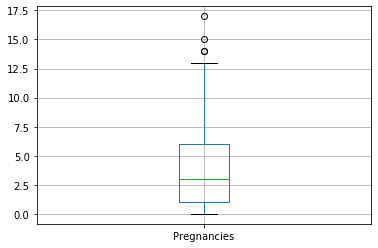

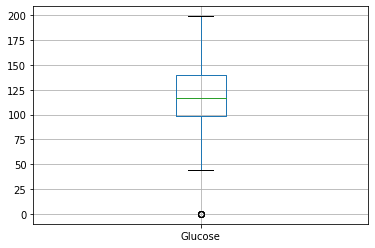

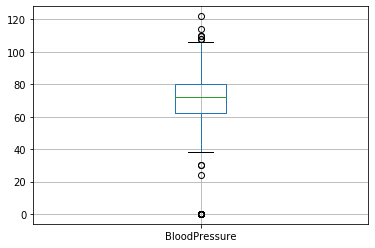

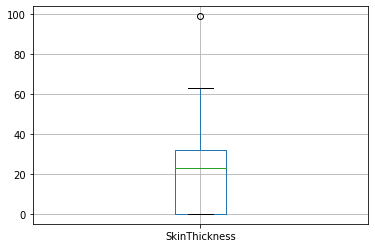

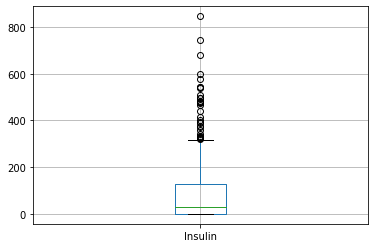

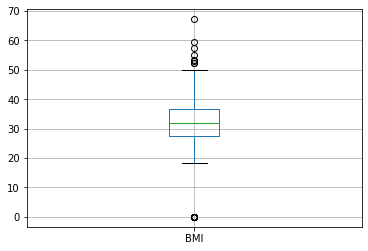

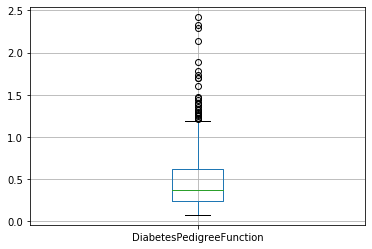

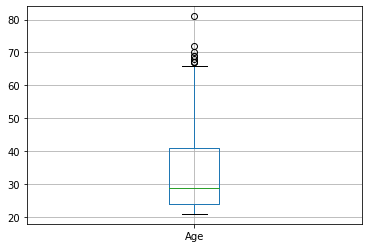

In [237]:
data = pd.read_csv("diabetes.csv")
print(data.info())
attributes = data.drop("Outcome",axis=1).columns
for attribute in attributes:
    plt.figure()
    data.boxplot([attribute])


In [238]:
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)
for attribute in attributes:
    q1 = data[attribute].quantile(0.25)
    q3 = data[attribute].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan


In [239]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               764 non-null    float64
 1   Glucose                   763 non-null    float64
 2   BloodPressure             719 non-null    float64
 3   SkinThickness             538 non-null    float64
 4   Insulin                   370 non-null    float64
 5   BMI                       749 non-null    float64
 6   DiabetesPedigreeFunction  739 non-null    float64
 7   Age                       759 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


In [240]:

def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp
for attribute in attributes:
    print(median_target(attribute))

   Outcome  Pregnancies
0        0          2.0
1        1          4.0
   Outcome  Glucose
0        0    107.0
1        1    140.0
   Outcome  BloodPressure
0        0           70.0
1        1           74.0
   Outcome  SkinThickness
0        0           27.0
1        1           32.0
   Outcome  Insulin
0        0    100.0
1        1    160.0
   Outcome   BMI
0        0  30.1
1        1  34.2
   Outcome  DiabetesPedigreeFunction
0        0                     0.325
1        1                     0.422
   Outcome   Age
0        0  26.0
1        1  36.0


In [241]:
data.loc[(data['Outcome'] == 0 ) & (data['Pregnancies'].isnull()), 'Pregnancies'] = 2.0
data.loc[(data['Outcome'] == 1 ) & (data['Pregnancies'].isnull()), 'Pregnancies'] = 4.0
data.loc[(data['Outcome'] == 0 ) & (data['DiabetesPedigreeFunction'].isnull()), 'DiabetesPedigreeFunction'] = 0.325
data.loc[(data['Outcome'] == 1 ) & (data['DiabetesPedigreeFunction'].isnull()), 'DiabetesPedigreeFunction'] = 0.422
data.loc[(data['Outcome'] == 0 ) & (data['Age'].isnull()), 'Age'] = 26.0
data.loc[(data['Outcome'] == 1 ) & (data['Age'].isnull()), 'Age'] = 36.0
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5


In [242]:
    
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


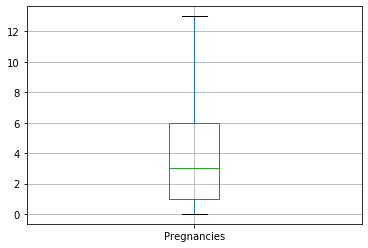

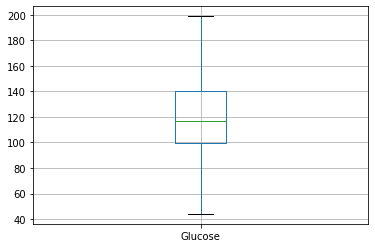

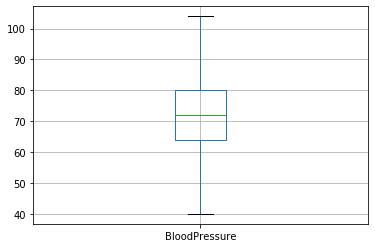

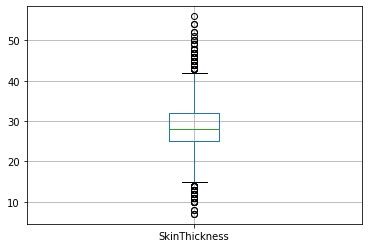

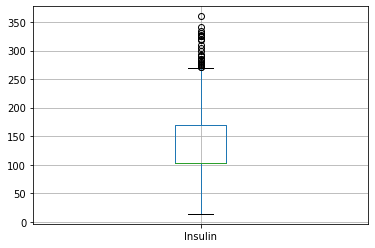

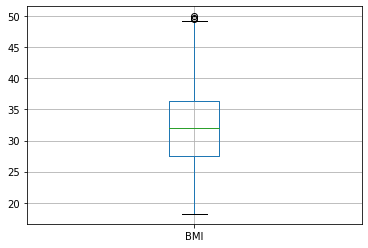

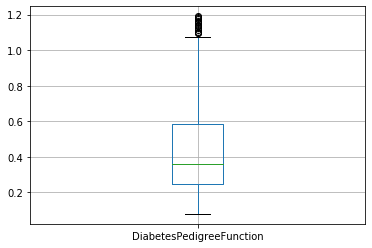

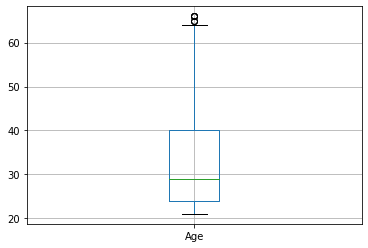

In [243]:
for attribute in attributes:
    plt.figure()
    data.boxplot([attribute])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


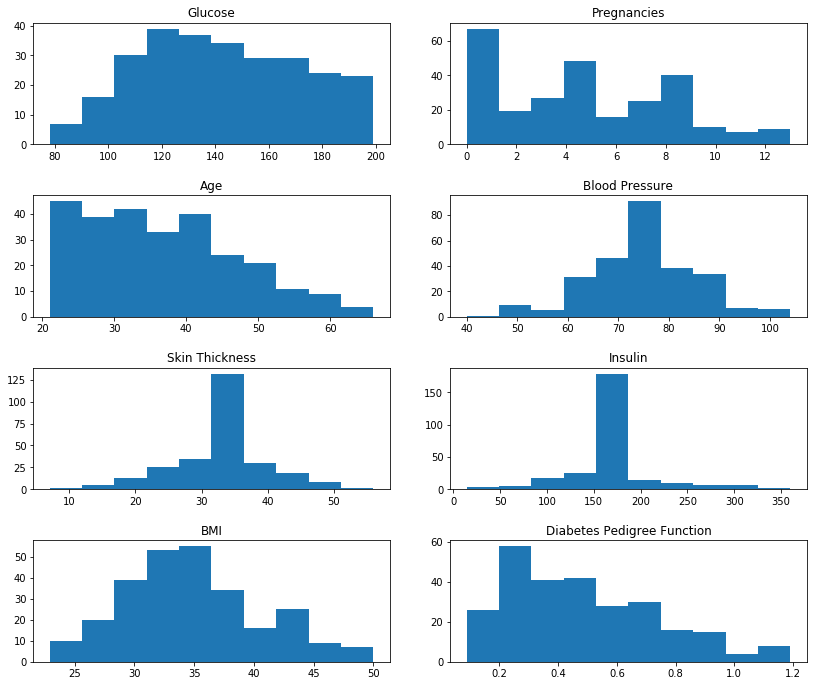

In [244]:

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
fig.tight_layout(pad=3.0)
ax[0,0].set_title('Glucose')
ax[0,0].hist(data.Glucose[data.Outcome==1]);
ax[0,1].set_title('Pregnancies')
ax[0,1].hist(data.Pregnancies[data.Outcome==1]);
ax[1,0].set_title('Age')
ax[1,0].hist(data.Age[data.Outcome==1]);
ax[1,1].set_title('Blood Pressure')
ax[1,1].hist(data.BloodPressure[data.Outcome==1]);
ax[2,0].set_title('Skin Thickness')
ax[2,0].hist(data.SkinThickness[data.Outcome==1]);
ax[2,1].set_title('Insulin')
ax[2,1].hist(data.Insulin[data.Outcome==1]);
ax[3,0].set_title('BMI')
ax[3,0].hist(data.BMI[data.Outcome==1]);
ax[3,1].set_title('Diabetes Pedigree Function')
ax[3,1].hist(data.DiabetesPedigreeFunction[data.Outcome==1]);


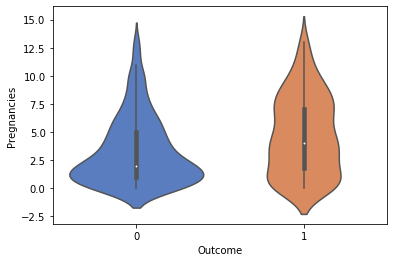

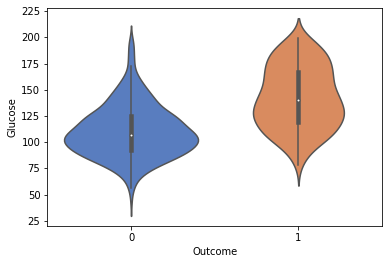

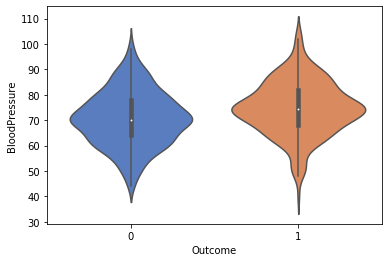

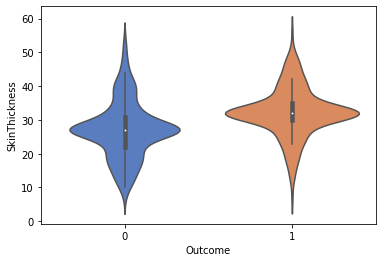

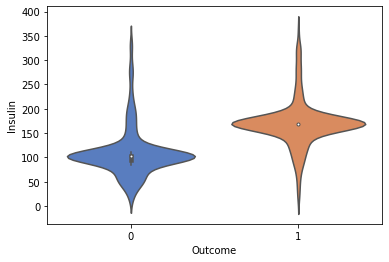

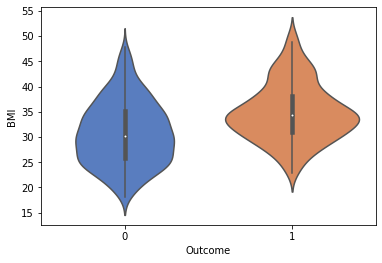

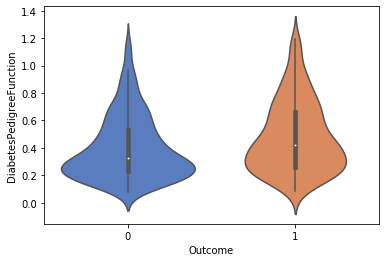

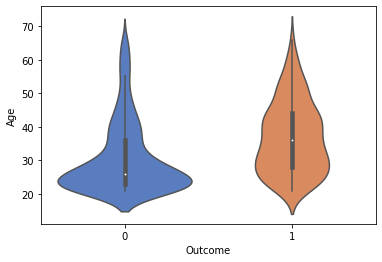

In [245]:

for attribute in attributes:
    plt.figure()    
    sns.violinplot(x="Outcome", y=attribute, data=data, palette="muted", split=True)

In [246]:

def z_score(df):
    """Function for apply z score standardization
       Input: dataframe to be standardized
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        print(column)
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std
    
data_std=z_score(data)

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count    768.00000  768.000000     768.000000     768.000000  768.000000   
mean       3.78776  121.677083      72.109375      28.919271  130.266927   
std        3.27019   30.464161      10.888873       8.362313   56.655168   
min        0.00000   44.000000      40.000000       7.000000   14.000000   
25%        1.00000   99.750000      64.000000      25.000000  102.500000   
50%        3.00000  117.000000      72.000000      28.000000  102.500000   
75%        6.00000  140.250000      80.000000      32.000000  169.500000   
max       13.00000  199.000000     104.000000      56.000000  360.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.195703                  0.428021   32.751302    0.348958  
std      6.418994                  0.245265   11.067972    0.476951  
min     18.200000                  

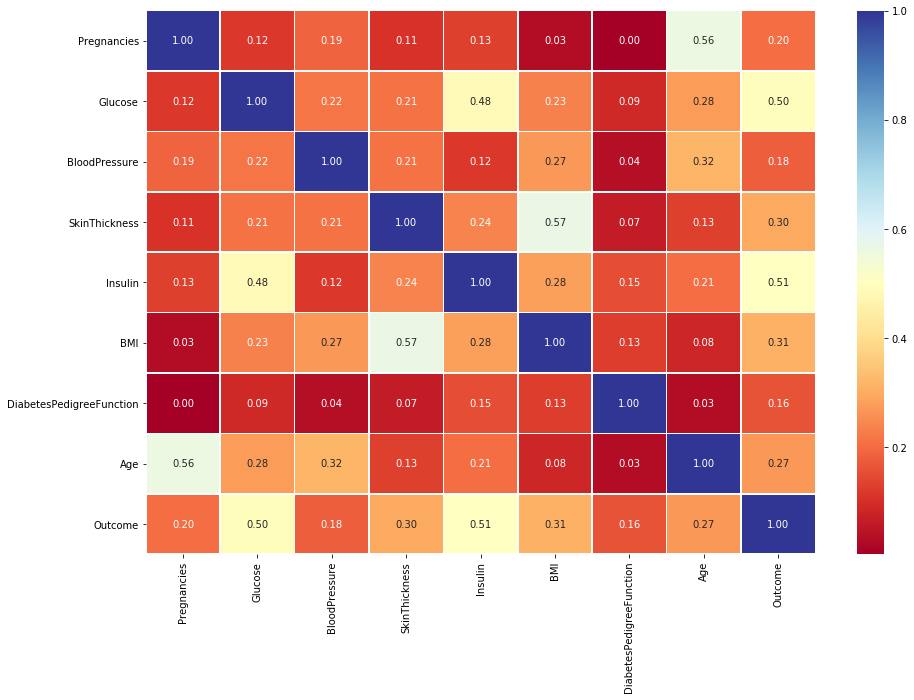

In [247]:
## It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="RdYlBu")

###### Distribution of data set 

In [248]:



y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)

X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)



# Models 

In [249]:

log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train);
## Evaluating the model
log_score=cross_val_score(log_reg, X, y, cv=8)
print("log_reg =",log_score.mean() )

## Build an model (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train);
## Evaluating the model
knn_score=cross_val_score(knn, X, y, cv=8)
print("knn",knn_score.mean())


## Build an model (Random forest classifier)
clfm= RandomForestClassifier()
clfm.fit(X_train,y_train);
## Evaluating the model
clfm_score=cross_val_score(clfm, X, y, cv=8)
print("clfm",clfm_score.mean())#

# Build an model (Support Vector Machine)
svm = SVC()
svm.fit(X_train,y_train)
## Evaluating the model
svm_score=cross_val_score(svm, X, y, cv=8)
print("svm",svm_score.mean())

ABC = AdaBoostClassifier(n_estimators=100, random_state=0)
ABC.fit(X, y)
ABC_score=cross_val_score(ABC, X, y, cv=8)
print("ABC",ABC_score.mean())


log_reg = 0.8059895833333333
knn 0.8515625
clfm 0.87890625
svm 0.8645833333333333
ABC 0.8763020833333333


In [250]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=10)
_, nn_acc = model.evaluate(X_test, y_test)


Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.7345
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.8192
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8306
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3769 - accuracy: 0.8388
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8404
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.8404
Epoch 7/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3500 - accuracy: 0.8550
Epoch 8/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3398 - accuracy: 0.8616
Epoch 9/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8550
Epoch 10/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3279 - accuracy: 0.8681
Epoch 11/

62/62 [==============================] - 0s 2ms/step - loss: 0.1002 - accuracy: 0.9691
Epoch 83/200
62/62 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9723
Epoch 84/200
62/62 [==============================] - 0s 2ms/step - loss: 0.1071 - accuracy: 0.9593
Epoch 85/200
62/62 [==============================] - 0s 3ms/step - loss: 0.1037 - accuracy: 0.9609
Epoch 86/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.9691
Epoch 87/200
62/62 [==============================] - 0s 2ms/step - loss: 0.1123 - accuracy: 0.9658
Epoch 88/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9707
Epoch 89/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0934 - accuracy: 0.9707
Epoch 90/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0957 - accuracy: 0.9707
Epoch 91/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0848 - accuracy: 0.9772
Epoch 92/200


62/62 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9886
Epoch 163/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9886
Epoch 164/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9902
Epoch 165/200
62/62 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9919
Epoch 166/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9886
Epoch 167/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9935
Epoch 168/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9821
Epoch 169/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9707
Epoch 170/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9837
Epoch 171/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.9870
Epoc

In [251]:
print('Accuracy of Neural network: %.2f' % (nn_acc*100))
print('Accuracy of logistic regression : %.2f' % (log_score.mean()*100))
print('Accuracy of Knn: %.2f' % (knn_score.mean()*100))
print('Accuracy of Random Forest Classifier : %.2f' % (clfm_score.mean()*100))
print('Accuracy of SVM : %.2f' % (svm_score.mean()*100))



Accuracy of Neural network: 79.87
Accuracy of logistic regression : 80.60
Accuracy of Knn: 85.16
Accuracy of Random Forest Classifier : 87.89
Accuracy of SVM : 86.46
